In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from glob import glob
from os.path import join
import xarray as xr

import time
import copy 
import datetime

import sys  
sys.path.insert(0, '../')

from soundings.deep_learning import mlutilities as ml
from soundings.deep_learning import tf_neuralnetwork as nn
from soundings.preprocessing import preprocess

from soundings.plotting import radiosonde_plotting
from soundings.utils import radiosonde_utils

from IPython.display import display
from ipywidgets import FloatProgress

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

vol = '/Users/stock/Development/research/soundings/data/raobs/arm-sgp/'

In [12]:
xar = xr.open_dataset(vol + '2020/sgpsondewnpnC1.b1.20200704.232600.cdf')

p = xar.pres.values
t = xar.tdry.values
td = xar.dp.values

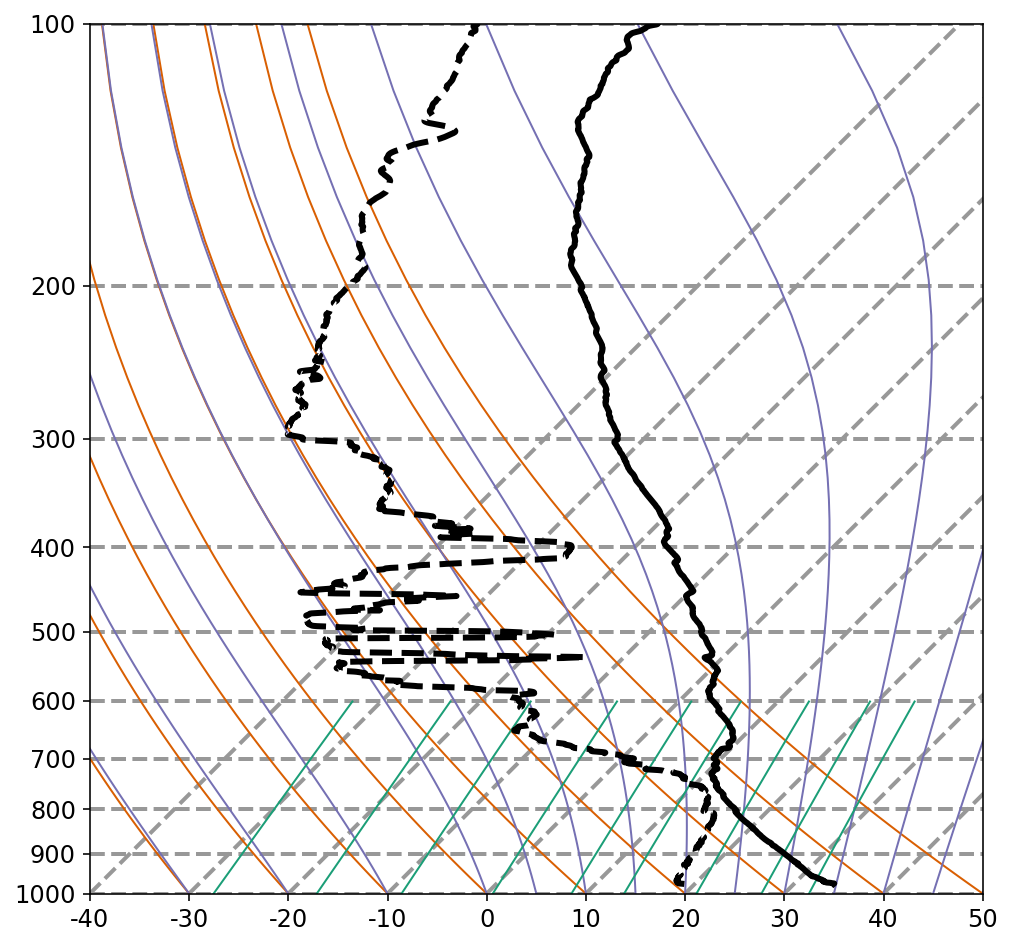

In [16]:
sounding_dict_for_metpy = dict()

sounding_dict_for_metpy[radiosonde_utils.PRESSURE_COLUMN_KEY] = p
sounding_dict_for_metpy[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = t
sounding_dict_for_metpy[radiosonde_utils.DEWPOINT_COLUMN_KEY] = td

radiosonde_plotting.plot_sounding(sounding_dict_for_metpy)
plt.show()

In [41]:
a = np.expand_dims(np.random.randint(0, 10, (2, 5)), axis=0)
b = np.expand_dims(np.random.randint(0, 10, (2, 5)), axis=0)
np.concatenate((a, b)).shape

(2, 2, 5)

In [2]:
SONDE_PROFILE_DIMS = 2000
PRESSURE = 0
TEMPERATURE = 1
DEWPOINT = 2

def valid_raob(xar):
    """Greater than N observations with all valid QC values
    """
    return (xar.time.values.size >= SONDE_PROFILE_DIMS and 
        all(np.unique(xar.qc_pres.values) == [0]) 
        and all(np.unique(xar.qc_tdry.values) == [0]) 
        and all(np.unique(xar.qc_dp.values) == [0]))

time: 13.420, avg: 0.013 seconds
2001: 874/1037 are valid


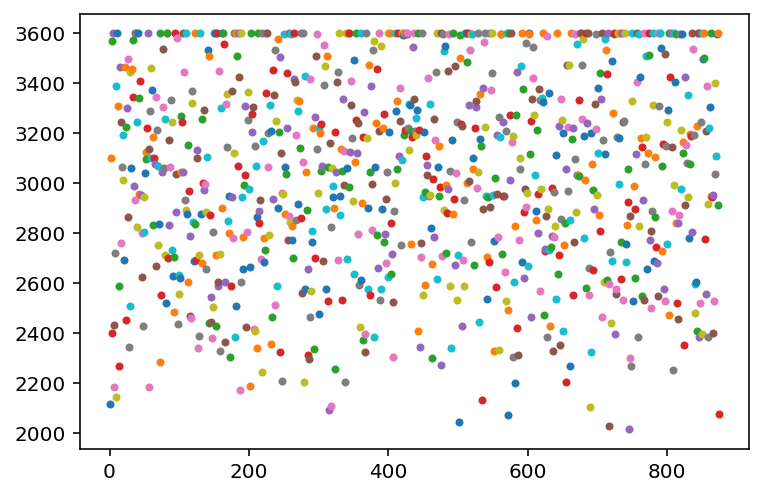

In [9]:
for year in range(2001, 2002): # 2021
    files = np.array(glob(join(vol, str(year), f'sgpsondewnpnC1.b1.*.cdf')))
    is_valid = np.ones(files.size, dtype=bool)
    s = time.time()
    for i, f in enumerate(files):
        xar = xr.open_dataset(f)
        if valid_raob(xar):
            plt.plot(valid, xar.pres.values.size, '.')
        else:
            is_valid[i] = False
        xar.close()
    e = time.time() - s
    print(f'time: {e:.3f}, avg: {e/files.size:.3f} seconds')
    print(f'{year}: {np.where(is_valid == True)[0].size}/{files.size} are valid')

In [3]:
files = np.array(glob(join(vol, '*/sgpsondewnpnC1.b1.*.cdf')))

# Samples, (Pressure, Temperature, Dewpoint), Pressure Dims
profiles = np.zeros((files.size, 3, SONDE_PROFILE_DIMS))
is_valid = np.ones(files.size, dtype=bool)

s = time.time()
for i, f in enumerate(files):
    xar = xr.open_dataset(f)
    if valid_raob(xar):
        p = preprocess.interpolate_profile(xar.pres.values, SONDE_PROFILE_DIMS)
        t = preprocess.interpolate_profile(xar.tdry.values, SONDE_PROFILE_DIMS)
        td = preprocess.interpolate_profile(xar.dp.values, SONDE_PROFILE_DIMS)
        profiles[i] = np.concatenate(([p], [t], [td]))
    else:
        is_valid[i] = False        
    xar.close()    
e = time.time() - s

profiles = profiles[np.where(is_valid)[0]]

print(f'time: {e:.3f}, avg: {e/files.size:.3f} seconds')
print(f': {np.where(is_valid == True)[0].size}/{files.size} are valid')

time: 510.336, avg: 0.019 seconds
: 24589/27209 are valid


In [4]:
profiles.shape

(24589, 3, 2000)

In [35]:
def plot_results(nnet, X, T, index=0):
    fig, axs = plt.subplots(1, 2, figsize=(16, 4))

    axs[0].plot(nnet.history['loss'], label='train')
    axs[0].plot(nnet.history['val_loss'], label='val')

    axs[1].plot(T[index,:], 'r', alpha=0.5, label='T')
    axs[1].plot(nnet.use(X[index:index+1,:])[0], 'r', label='Y')
    [axi.legend() for axi in axs.ravel()];

## Fully Connected NN

In [46]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(profiles, profiles, (0.8,0.2), shuffle=True)

input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

Xtrain = Xtrain[:, input_dims, :]
Xtrain = Xtrain.reshape((-1, Xtrain[0,:].size))
Ttrain = Ttrain[:, TEMPERATURE, :]

Xtest = Xtest[:, input_dims, :]
Xtest = Xtest.reshape((-1, Xtest[0,:].size))
Ttest = Ttest[:, TEMPERATURE, :]
    
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((19671, 6000), (19671, 2000), (4918, 6000), (4918, 2000))

In [48]:
nnet = nn.NeuralNetwork(Xtrain.shape[1], [512, 256, 128, 256, 512], Ttrain.shape[1], activation='relu')
nnet.train(Xtrain, Ttrain, 25, 64, method='adam', verbose=True, 
           learning_rate=0.005, validation=[Xtest, Ttest])

epoch: 0, loss: 0.21650
epoch: 5, loss: 0.08252
epoch: 10, loss: 0.07236
epoch: 15, loss: 0.07114
epoch: 20, loss: 0.06261
epoch: 24, loss: 0.06251
finished!


NeuralNetwork(6000, [512, 256, 128, 256, 512], 2000)
  Final objective value is 0.06251 in 183.4400 seconds.

In [49]:
nnet.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6000)]            0         
_________________________________________________________________
dense (Dense)                (None, 512)               3072512   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024 

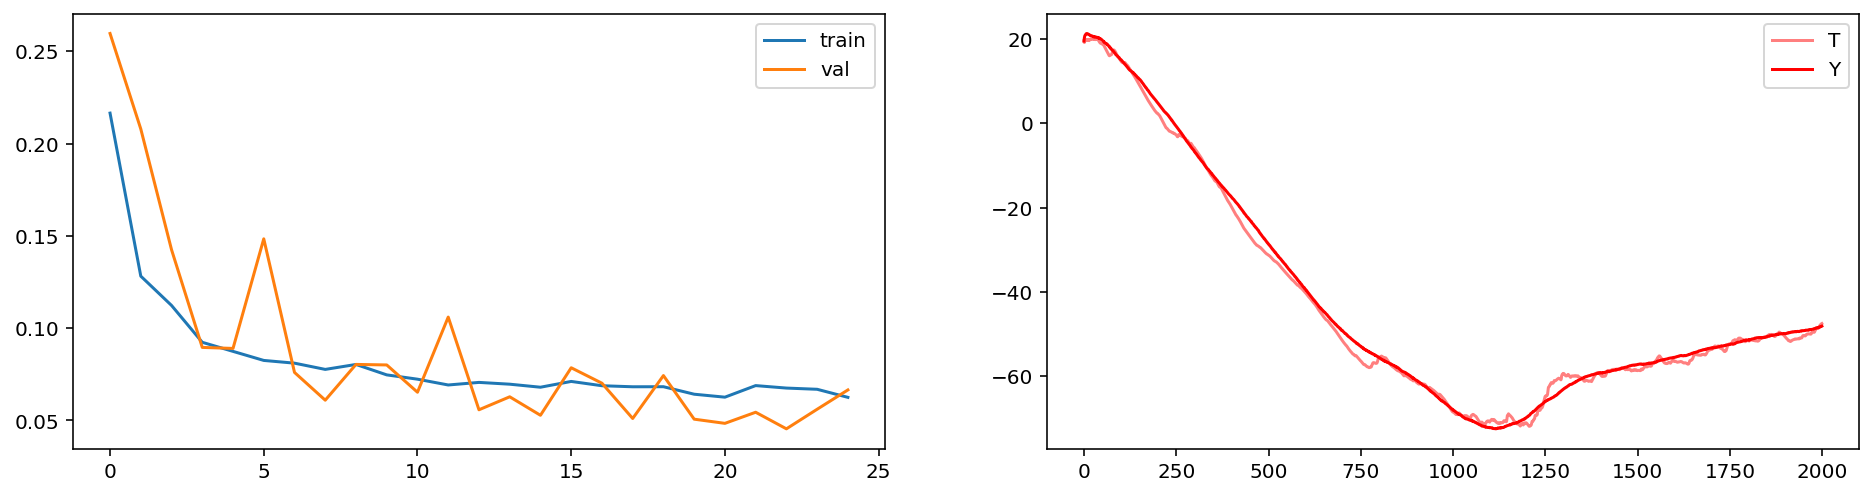

In [50]:
plot_results(nnet, Xtest, Ttest, index=27)

## Convolutional NN

In [42]:
Xtrain, Ttrain, Xtest, Ttest = ml.partition(profiles, profiles, (0.8,0.2), shuffle=True)

input_dims = [PRESSURE, TEMPERATURE, DEWPOINT]

Xtrain = np.swapaxes(Xtrain[:, input_dims, :], 1, 2)
Ttrain = Ttrain[:, TEMPERATURE, :]

Xtest = np.swapaxes(Xtest[:, input_dims, :], 1, 2)
Ttest = Ttest[:, TEMPERATURE, :]
    
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((19671, 2000, 3), (19671, 2000), (4918, 2000, 3), (4918, 2000))

In [43]:
nnet = nn.ConvolutionalNeuralNetwork(Xtrain.shape[1:], [3]*4, [(10, 1)]*4,
                                     Ttrain.shape[1], activation='relu')
nnet.train(Xtrain, Ttrain, 15, 128, method='adam', verbose=True, 
           learning_rate=0.001, validation=[Xtest, Ttest])

epoch: 0, loss: 0.30954
epoch: 5, loss: 0.01814
epoch: 10, loss: 0.00901
epoch: 14, loss: 0.00778
finished!


ConvolutionalNeuralNetwork((2000, 3), [3, 3, 3, 3], [(10, 1), (10, 1), (10, 1), (10, 1)], 2000)
  Final objective value is 0.00778 in 122.0197 seconds.

In [44]:
nnet.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2000, 3)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1991, 3)           93        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 995, 3)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 986, 3)            93        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 493, 3)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 484, 3)            93        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 242, 3)            0     

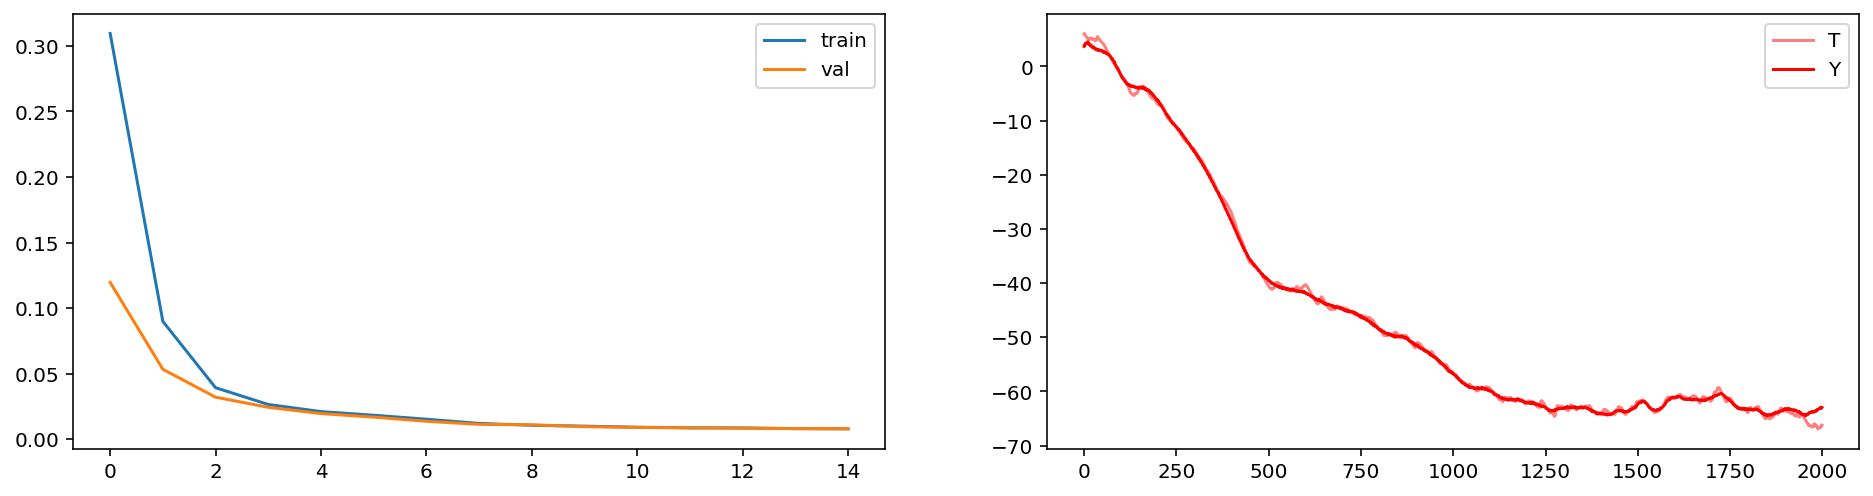

In [45]:
plot_results(nnet, Xtest, Ttest, index=0)

In [51]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                      profiles:  1.1 GiB
                         files: 10.9 MiB
                      is_valid: 26.7 KiB
                 FloatProgress:  1.0 KiB
                           _i3:  926.0 B
                           _i1:  780.0 B
                          _i18:  734.0 B
                          _i20:  734.0 B
                          _i22:  734.0 B
                           _oh:  656.0 B
